# Learning Goals
By the end of this tutorial, you will:
* Understand how to query data on a target from the MAST archive.
* Be able to plot a timeline of all observations of the target.
* Learn to plot a spectrum from any historical observation. 
* Make your own comparisons and conclusions based on the target. 

# Introduction

Quasars are extremely luminous astronomical objects that can be found at the center of some galaxies. They are powered by gas spiraling at high velocity into a super-massive black hole. The brightest quasars are capable of outshining all the stars in their galaxy, they can be seen from billions of light-years away. The first quasar ever discovered is called **3c273**, it is one of the most luminous quasars and therefore one of the most luminous objects in the observable universe. It is at a distance of 749 Megaparsecs [1 Megaparsec = 1 million parsecs = 3.26 million lightyears] with an absolute magnitude of −26.7, meaning that if it were at a distance of 10 parsecs, it would be as bright in our sky as the Sun. <br>
    
Quasar **3c273** is the target we will focus on in this tutorial. We will first gather all the observations of this quasar from the MAST archive. Then, we will plot those observations as a function of wavelength versus time. Finally, we will plot a spectrum from one of the observations. These two plots should help us to understand what the history of this quasar looks and then we can try to draw our own conclusions.

# Imports
The following cell holds the imported packages. These packages are necessary for running the rest of the cells in this notebook. A description of each import is as follows:

* *numpy* to handle array functions
* *pandas* to handle date conversions
* *fits from astropy.io* for accessing FITS files
* *Table from astropy.table* for creating tidy tables of the data
* *matplotlib.pyplot* for plotting data
* *Mast and Observations from astroquery.mast* for querying data and observations from the MAST archive


In [12]:
%matplotlib inline
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
from astroquery.mast import Mast
from astroquery.mast import Observations
from astroquery.mast import Catalogs

# Main Content

## Gather the Data

We are going to use the **astroquery.mast Observations** package to gather our data from the MAST Archive. There are a number of ways to go about querying data with this package. For our purposes, we will be using the **Observations.query_object()** function which takes in the name of the target and optionally, a radius around the target (the default is 0.2 degrees if not provided). You can find a link to the MAST data column descriptions in the **"Additional Resources"** section below. 


In [2]:
#define target name
target_name = "3c273"

#We'll name the data "obs_table" for "observations table"
obs_table = Observations.query_object(target_name)

#lets print out the first 10 entries
print(obs_table[:10])  

intentType obs_collection provenance_name ... srcDen  obsid        distance     
---------- -------------- --------------- ... ------ -------- ------------------
   science          WUPPE              -- ... 5885.0   389158 0.5380910908285884
   science          WUPPE              -- ... 5885.0   389159 0.5380910908285884
   science           TESS            SPOC ...    nan 71644386                0.0
   science           TESS            SPOC ...    nan 71498620                0.0
   science           TESS            SPOC ...    nan 71498623                0.0
   science          SWIFT              -- ... 5885.0  1417744                0.0
   science          SWIFT              -- ... 5885.0  1420859                0.0
   science          SWIFT              -- ... 5885.0  1441576                0.0
   science          SWIFT              -- ... 5885.0  1417743                0.0
   science          SWIFT              -- ... 5885.0  1429298                0.0


### Compile necessary variables for plotting
Before we start parsing our observations table, lets recall what we want to do with it. <br> 
<br>
First, we want to plot an Historical Observational Coverage Plot, where the x-axis will be time and the y-axis will be wavelength. We are also going to want to label or color each observation according to what mission it corresponds to. So, we are going need a variable for:
* array of times of all observations
* array of wavelengths of all observations
* array of mission names of all observations. <br> 

Some modifications to the quieried data will be desired for easy visualization. 1) We will want to convert the Modified Julian Date returned from our MAST query to a Calendar Date so when we plot the timeline, it will be easy to tell when each observation was made. 2) MAST only holds columns for the minimum and maximum wavelength of the observation, for the Historic Observational Coverage plot, we only want one wavelength per time so we will calculate the median between each min and max wavelength value. <br>
<br>

In [3]:
#Parse the observations table to get the Time data
obs_times = obs_table["t_min"]
#Convert MJD to Calendar Date:
#initialize list for times as calendar dates
times = []
#loop through times quieried from MAST
for t in obs_times:
    #convert MJD to Julian date
    t = t + 2400000.5
    #convert Julian date to Calendar date 
    time = pd.to_datetime(t, unit = 'D', origin = 'julian')
    #add converted date to times list
    times.append(time.to_numpy())
#change list to numpy array for easy plotting
times = np.array(times)

#Parse observations table to get the wavelength data
wavelength_min = obs_table["em_min"]
wavelength_max = obs_table["em_max"]
#Calculate the median between each wavelength min/max value:
#initialize list for median wavelengths
waves = []
#loop through the number of wavelengths
for wave in range(len(wavelength_max)):
    #add each median value to a list
    waves.append((wavelength_max[wave]-wavelength_min[wave])/2)
#change list to numpy array and convert units from nanometers to meters 
waves = np.array(waves)*1e-9

#Parse the observations table to get the mission names data
mission = obs_table["obs_collection"]
mission = np.array(mission)

## Historical Observational Coverage Plot 

We want to visualize the history of observations of 3c273 according to the wavelength of the observation. This plot will tell us much more if we change the color of each point to indicate which mission made the observation. 

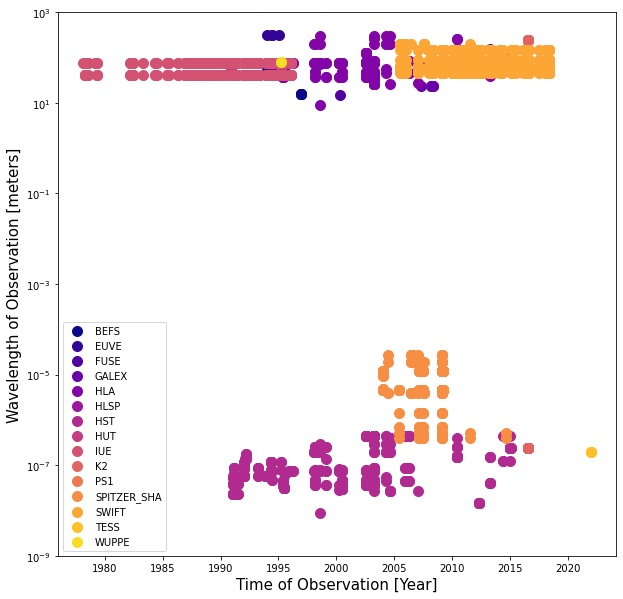

In [4]:
#make plot axes
fig = plt.figure()
fig.set_size_inches(10,10)
ax = fig.add_subplot()
        
#get color for every unique mission name
cm = plt.cm.get_cmap("plasma") 
num_colors = len(np.unique(mission))
ax.set_prop_cycle(color = [cm(1.*i/num_colors) for i in range(num_colors)])

#loop through the mission names
for i in np.unique(mission):
    #filter times and wavelengths by mission name
    ind = np.where(mission == i)
    #plot it
    ax.scatter(times[ind], waves[ind], label = i, s = 100)#, edgecolor = 'darkgrey')

#place the legend
plt.legend()  
#scale the y-axis to log for better visualization
plt.yscale("log")
#set the limits of the y-axis, you can change this to see different wavelength ranges later
plt.ylim(10**-9,10**3)
#set the label of the x and y axes
plt.xlabel("Time of Observation [Year]", fontsize = 15)
plt.ylabel("Wavelength of Observation [meters]", fontsize = 15)
#show the plot
plt.show()


## Plot Spectrum

### Choose a single observation

Second, we want to plot a spectrum from one of our observations, where the x-axis will be wavelength and the y-axis will be flux (or what you can call brightness). For this plot we will need a variable for:

* array of wavelength range of one observation
* array of fluxes of one observation. 
<br>

We can use our Historical Observational Coverage plot to choose which observation to plot. 

In [39]:
#this cell is in progress
single_obs = Observations.query_criteria(obs_collection="HST",target_name = "3c273")

data_products = Observations.get_product_list(single_obs)

product = data_products[0]["dataURI"]

print(product)

result = Observations.download_file(product)   

print(result)


#or query like this?

# catalog_data = Catalogs.query_object("3c273", radius=.01, catalog="HSC")
# print(catalog_data)

mast:HLA/url/cgi-bin/preview.cgi?dataset=hst_07568_01_wfpc2_f300w_pc
INFO: Found cached file /Users/emmalieb/Documents/GitHub/notebooks-stsci/notebooks/MAST/plotting_quasar_observations/preview.cgi?dataset=hst_07568_01_wfpc2_f300w_pc. [astroquery.query]
('COMPLETE', None, None)


# Exercises


# Additional Resources

You can find the name of each data column in our queried table here: https://mast.stsci.edu/api/v0/_c_a_o_mfields.html 

The SIMBAD profile on 3c273 can be found here: http://simbad.u-strasbg.fr/simbad/sim-id?Ident=3C+273 

Check out this youtube video by David Butler giving a 1 minute summary of **3c273**: https://youtu.be/VfBOIcKU8xU

Here is a neat article written about **3c723** by Phil Plait for SYFY: https://www.syfy.com/syfy-wire/most-distant-astronomical-object-ever-seen-in-1962 

# About this Notebook

**Author**: Emma Lieb <br>
**Last updated:** 10 Jun 2022

# Citations

* [Citation for `astropy`](https://www.astropy.org/acknowledging.html)
